In [1]:
"""Basic word2vec example."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from tempfile import gettempdir
import zipfile
import json

import numpy as np
from six.moves import urllib
from six.moves import xrange
import tensorflow as tf

from matplotlib import rcParams
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

# matplotlib输出中文的时候会出现乱码，对matplotlib进行设置，使之可以输出中文
myfont = FontProperties(fname='wqy-microhei.ttc', size=20)
rcParams['axes.unicode_minus'] = False  # 解决负号‘-‘显示为方块的问题

# Step 1: Download the data.
# url = 'http://mattmahoney.net/dc/'


# pylint: disable=redefined-outer-name
def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    local_filename = os.path.join(gettempdir(), filename)
    if not os.path.exists(local_filename):
        local_filename, _ = urllib.request.urlretrieve(url + filename,
                                                       local_filename)  # urllib.request.urlretrieve下载数据的压缩文件并核对文件尺寸
    statinfo = os.stat(local_filename)  # os.stat() 用于在给定的路径上执行一个系统 stat 的调用
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify ' + local_filename +
                        '. Can you get to it with a browser?')
    return local_filename


# filename = maybe_download('text8.zip', 31344016)
filename = './QuanSongCi.txt'  # 文件名


# 读取数据，将数据转成单词列表
def read_data(filename):
    with open(filename, encoding="utf-8") as f:
        data = f.read()
    data = list(data)
    return data


vocabulary = read_data(filename)
print('Data size', len(vocabulary))

Data size 1903073


In [2]:
# Step 2: Build the dictionary and replace rare words with UNK token.
# vocabulary_size = 50000
vocabulary_size = 5000  # 取出现次数最多的前5000个单字符


def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]  # 生成列表count
    count.extend(collections.Counter(words).most_common(n_words - 1))

    dictionary = dict()  # 生成字典dictionary
    for word, _ in count:
        dictionary[word] = len(dictionary)

    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 0)
        if index == 0:
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count

    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))  # 将key和value互换生成新的reversed_dictionary

    return data, count, dictionary, reversed_dictionary


# Filling 4 global variables:
# data - list of codes (integers from 0 to vocabulary_size-1).
#   This is the original text but words are replaced by their codes
# count - map of words(strings) to count of occurrences
# dictionary - map of words(strings) to their codes(integers)
# reverse_dictionary - maps codes(integers) to words(strings)
data, count, dictionary, reversed_dictionary = build_dataset(vocabulary,
                                                            vocabulary_size)

print('Most common words (+UNK)', count[:5])  # 打印vocabulary中最高频出现的词汇及其数量
print('Sample data', data[:10], [reversed_dictionary[i] for i in data[:10]])

#json.dump()函数的使用，保存json文件
with open("./dictionary.json","w",encoding='utf-8') as f:
    json.dump(dictionary,f)

with open("./reversed_dictionary.json","w",encoding='utf-8') as f:
    json.dump(reversed_dictionary,f)
    
del vocabulary  # 删除原始单词列表，可以节约内存

Most common words (+UNK) [['UNK', 1196], ('。', 149620), ('\n', 117070), ('，', 108451), ('、', 19612)]
Sample data [1503, 1828, 2, 2, 40, 613, 47, 9, 111, 117] ['潘', '阆', '\n', '\n', '酒', '泉', '子', '（', '十', '之']


In [3]:
# Step 3: Function to generate a training batch for the skip-gram model.
data_index = 0


def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[context_word]
        if data_index == len(data):
            buffer.extend(data[0:span])
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels


batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print(batch[i], reversed_dictionary[batch[i]],'->', labels[i, 0], reversed_dictionary[labels[i, 0]])
# 输出的是每个sample字（包括符号）所对应的前或后的labels（字于符号）

1828 阆 -> 2 

1828 阆 -> 1503 潘
2 
 -> 2 

2 
 -> 1828 阆
2 
 -> 40 酒
2 
 -> 2 

40 酒 -> 613 泉
40 酒 -> 2 



In [4]:
# Step 4: Build and train a skip-gram model.
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1  # How many words to consider left and right.
num_skips = 2  # How many times to reuse an input to generate a label.
num_sampled = 64  # Number of negative examples to sample.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. These 3 variables are used only for
# displaying model accuracy, they don't affect calculation.
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

graph = tf.Graph()

with graph.as_default():
    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)  # 将前面随机产生的valid_examples转为TensorFlow中的constant

    # Ops and variables pinned to the CPU because of missing GPU implementation
    #with tf.device('/gpu:0'):  # 我用GPU
    
        # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0,
                          1.0))  # tf.random_uniform()随机生成所有单词的词向量embeddings
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)  # tf.nn.embedding_lookup查找输入train_inputs对应的向量embed

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(
                                embedding_size)))  # tf.truncated_normal初始化NCE loss中的权重参数nce_weigths
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    # Explanation of the meaning of NCE loss:
    #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
    # tf.nn.nce_loss计算学习出的词向量embedding在训练数据上的loss,然后使用tf.reduce_mean进行汇总
    loss = tf.reduce_mean(
        tf.nn.nce_loss(weights=nce_weights,
                       biases=nce_biases,
                       labels=train_labels,
                       inputs=embed,
                       num_sampled=num_sampled,
                       num_classes=vocabulary_size))

    # Construct the SGD optimizer using a learning rate of 1.0. 定义优化器为SGD
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

    # Add variable initializer.
    init = tf.global_variables_initializer()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [5]:
# Step 5: Begin training.
num_steps = 100001

with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print('Initialized')

    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reversed_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = 'Nearest to %s:' % valid_word
                for k in xrange(top_k):
                    close_word = reversed_dictionary[nearest[k]]
                    log_str = '%s %s,' % (log_str, close_word)
                print(log_str)
    final_embeddings = normalized_embeddings.eval()
    np.save('embedding.npy', final_embeddings)


Initialized
Average loss at step  0 :  226.58351135253906
Nearest to 头: 噬, 蜡, 猜, 秀, 瑞, 否, 拓, 囿,
Nearest to 新: 鲵, 升, 舸, 朋, 地, 诛, 沽, 枫,
Nearest to 如: 焙, 吉, 死, 鼠, 蘩, 泉, 徭, 鞋,
Nearest to 空: 父, 饾, 粹, F, 沫, 致, 舍, 傅,
Nearest to 有: 桔, 喻, 事, 撇, 通, 真, 辞, 衔,
Nearest to 行: 迷, 显, 能, 厥, 甬, 怡, 晦, 心,
Nearest to 重: 潆, 惮, 籁, 埃, 逄, 蚓, 肴, 谋,
Nearest to 金: 凑, 茨, 案, 嶓, 猊, 树, 咬, 麽,
Nearest to 南: 条, 玄, 阻, 黑, 余, 澳, 檎, 鲲,
Nearest to 更: 初, 诰, 蝠, 鹊, 郊, 滂, 霪, 忿,
Nearest to 西: 咻, 霆, 卜, 诡, 袍, 讼, 榜, 易,
Nearest to 青: 踞, 璁, 罪, 埭, 其, 武, 缯, 待,
Nearest to 今: 洒, 投, 戛, u, 乱, 核, 骞, 癯,
Nearest to 流: 邪, 宇, 卜, 翕, 启, 帙, 讹, 相,
Nearest to 似: 舜, 舞, 鶗, 基, 陡, 丝, 柚, 谆,
Nearest to 笑: 叨, 偶, 蟾, 丹, 记, 侣, 诬, 罚,
Average loss at step  2000 :  21.369306562542917
Average loss at step  4000 :  5.321926865696907
Average loss at step  6000 :  4.891806077122689
Average loss at step  8000 :  4.675784499645233
Average loss at step  10000 :  4.601058416128159
Nearest to 头: 秀, 蜡, 瑞, 猜, 咏, 否, 噬, 寿,
Nearest to 新: 舸, 升, 诛, 枫, 鲵, 干, 清, 地,
Nearest to 如: 乃,

Average loss at step  92000 :  4.04765447986126
Average loss at step  94000 :  4.083732114434242
Average loss at step  96000 :  4.052907661914825
Average loss at step  98000 :  4.078750155329704
Average loss at step  100000 :  4.065463450849056
Nearest to 头: 首, 兢, 南, 咏, 上, 套, 用, 孟,
Nearest to 新: 初, 浓, 緺, 鲵, 泚, 昆, 贶, 盖,
Nearest to 如: 似, 妨, 侑, 而, 醁, 沤, 迄, 亦,
Nearest to 空: 璧, 暗, 滋, 独, 萦, 坤, 霙, 浚,
Nearest to 有: 是, 在, 把, 存, 与, 冈, 抱, 编,
Nearest to 行: 警, 显, 赓, 坐, 去, 婪, 归, 憔,
Nearest to 重: 峻, 籁, 壕, 会, 埃, 筛, 慧, 再,
Nearest to 金: 玉, □, 宝, 猊, 案, 姆, 济, 狡,
Nearest to 南: 西, 北, 头, 矍, 沧, 岘, 急, 筲,
Nearest to 更: 便, 最, 悴, 共, 处, 纱, 夜, 铄,
Nearest to 西: 东, 南, 俳, 临, 单, 吴, 好, 北,
Nearest to 青: 碧, 玠, 踞, 埭, 笃, 绿, 垂, 芭,
Nearest to 今: 昨, 渑, 来, 他, 此, 嗔, 亡, 何,
Nearest to 流: 位, 讹, 券, 邪, 麟, 呜, 迁, 凿,
Nearest to 似: 如, 是, 知, 记, 聪, 醁, 鶗, 掉,
Nearest to 笑: 罚, 醉, 殇, 倩, 恹, 掬, 獭, 管,


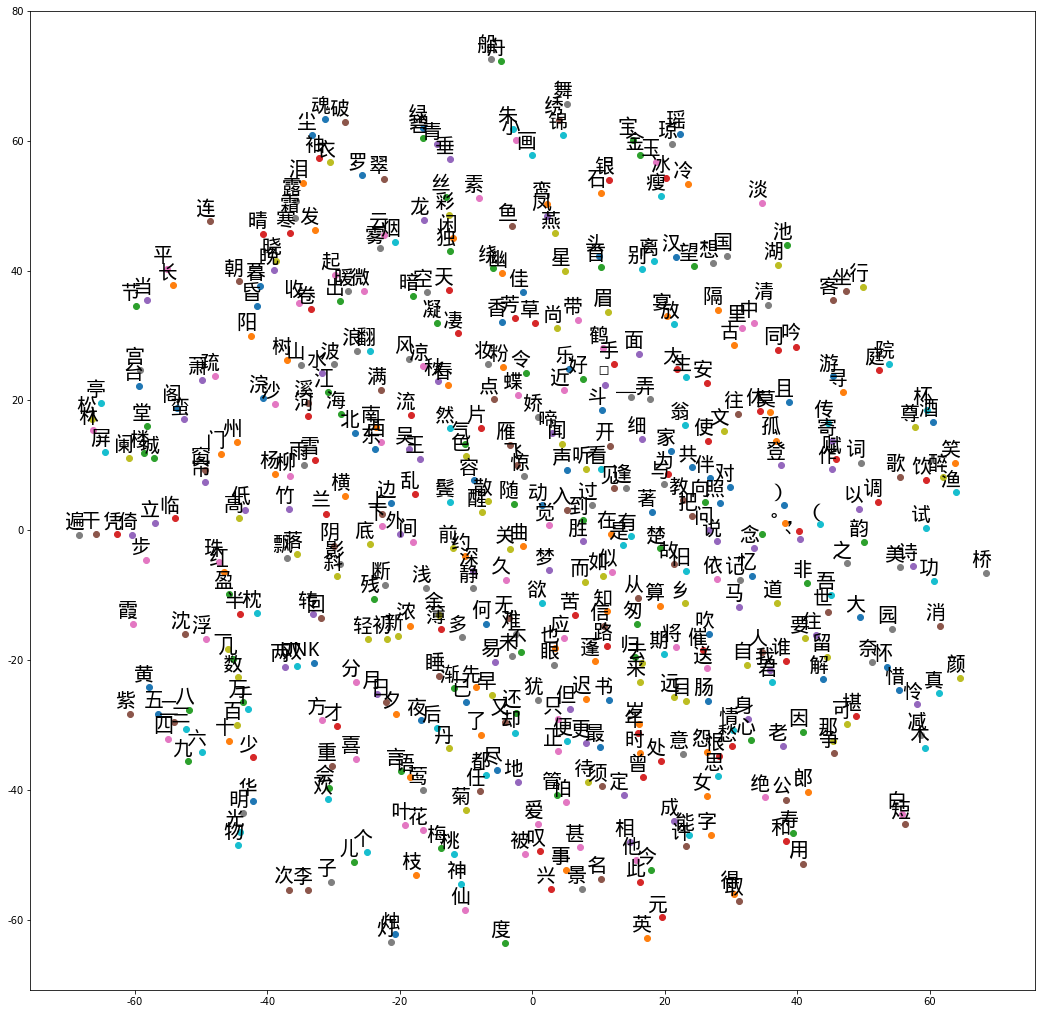

In [6]:
# Step 6: Visualize the embeddings.


# pylint: disable=missing-docstring
# Function to draw visualization of distance between embeddings.
def plot_with_labels(low_dim_embs, labels, filename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                     fontproperties=myfont)

    plt.savefig(filename)
    # plt.show()


try:
    # pylint: disable=g-import-not-at-top
    from sklearn.manifold import TSNE  # 实现降维，将原始的128维嵌入向量降到2维
    import matplotlib.pyplot as plt

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reversed_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels, 'tsne.png')

except ImportError as ex:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')
    print(ex)